창원대학교 신소재공학부 유동해석, 소성가공, 유동해석특론 교과목에 활용될 자료입니다. 

창원대 신소재공학부 [정영웅](mailto:yjeong@changwon.ac.kr)

yjeong[at]changwon.ac.kr

In [1]:
%pylab inline
exp=np.exp

Populating the interactive namespace from numpy and matplotlib


##  Problem description:
The main equation that is given to us is

$$
\exp(-y)y^{n} \Big(\frac{dy}{dt}\Big)^m=f_0 \exp(-x)x^{n} \Big(\frac{dx}{dt}\Big)^m
$$

- $f_0$ is a constant

- $m$ and $n$ are material parameters associated with strain rate sensitivity and strain hardening, respectively.

- We specify a small time increment ${\Delta t}$, which is fixed as a constant.

- The strain rate of A region is given. Therefore, $\frac{dx}{dt}$ is known so that $\Delta x$ can be obtained as $\dot{x}\Delta t$

We'll need to find the corresponding $\Delta y$.

$$
\exp(-y_{(k+1)})(y_{(k+1)})^{n} \Big(\frac{y_{(k+1)}-y_{(k)}}{\Delta t}\Big)^m=f_0 \exp(-x_{(k+1)})(x_{(k+1)})^{n} (\dot{x})^m
$$

where the subscripts $_{(k)}$ and $_{(k+1)}$ denote the previous and next steps, respectively.

To solve the above equation as a function of $\Delta y$ for the current increment step, we use Newton-Raphson method.

### NR algorithm

$$
F(y_{(k+1)})=
\exp(-y_{(k+1)})(y_{(k+1)})^{n} \Big(\frac{y_{(k+1)}-y_{(k)}}{\Delta t}\Big)^m-f_0 \exp(-x_{(k+1)})(x_{(k+1)})^{n} (\dot{x})^m
$$

Yet, for a given increment, the second term can be treated as a constant for each individual incremental step so that

$$
F( y_{(k+1)})=
\exp(-y_{(k+1)})(y_{(k+1)})^{n} \Big(\frac{y_{(k+1)}-y_{(k)}}{\Delta t}\Big)^m-C
$$

where $C=f_0 \exp(-x_{(k+1)})(x_{(k+1)})^{n} (\dot{x})^m$

The partial derivative is:

$$
\frac{\partial F(y_{(k+1)})}{\partial  y_{(k+1)}}= 
 -\exp(-y_{(k+1)}) (y_{(k+1)})^{n}                   \Big(\frac{y_{(k+1)}-y_{(k)}}{\Delta t}\Big)^m
+n\exp(-y_{(k+1)}) (y_{(k+1)})^{n-1}                 \Big(\frac{y_{(k+1)}-y_{(k)}}{\Delta t}\Big)^m
+m\exp(-y_{(k+1)}) (y_{(k+1)})^{n} \frac{1}{\Delta t}\Big(\frac{y_{(k+1)}-y_{(k)}}{\Delta t}\Big)^{m-1}
$$

### Implementation

In [2]:
def fprime(yk1,yk,n,m,dt):
    return -exp(-yk1)*(yk1)**(n)   *((yk1-yk)/dt)**m \
     +  (n)*exp(-yk1)*(yk1)**(n-1) *((yk1-yk)/dt)**m  \
     +   m *exp(-yk1)*(yk1)**(n)/dt*((yk1-yk)/dt)**(m-1)
def obj(yk1,yk,n,m,dt,C):
    return exp(-yk1)*(yk1)**(n)*((yk1-yk)/dt)**m-C
def calC(f0,xk1,n,m,xdot):
    return f0*exp(-xk1)*xk1**(n)*(xdot**m)
def nr(f0,yk,xk1,n,m,dt,xdot,guess):
    dx=xdot*dt
    yk1=guess
    ## Calculate C
    C = calC(f0,xk1,n,m,xdot)
    
    tol=1e-9
    f=tol*2.
    nit=0
    
    while (abs(f)>tol):
        nit=nit+1
        f=obj(yk1,yk,n,m,dt,C)
        df=fprime(yk1,yk,n,m,dt)
        yk1=yk1-f/df
        
        if nit>100: raise IOError, 'Diverged'
    
    return dx,yk1,f

### Test NR algorithm

In [3]:
%time
dt=0.05
xdot=0.05
dx=dt*xdot
f0=0.9999
n=0.5
m=0.02

##   f0 , yk , xk1, n,   m , dt, xdot,guess on dy
nr(  f0,  0,   dx,  n,   m,  dt, xdot, dx)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


(0.0025000000000000005, 0.0024995169309590076, -2.2120170278805418e-10)

In [4]:
def xy_curve(dt,xdot,f0,n,m):
    xk=0.
    yk=0.
    yk1=0.
    dx=xdot*dt
    xk1=xk+dx
    nit=0
    xs=[0]
    ys=[0]
    fv=[0]
    while xk1<=0.4:
        nit=nit+1
        
        if nit==1: guess=dx
        else: guess = yk+dy
        
        dx,yk1,fval=nr(f0,yk,xk1,n,m,dt,xdot,guess)
        
        dy=yk1-yk
        yk=yk1
        fv.append(fval)
            
        xs.append(xk1)
        ys.append(yk1)
        
        xk1=xk1+xdot*dt
                
    return xs,ys,fv

- Test the algorithm by calculate the cases of $m=0.1, 0.05, 0.025, 0.01$ and $0$.

- You'll find an abnormal behavior in case of $m=0$. 

- Why?

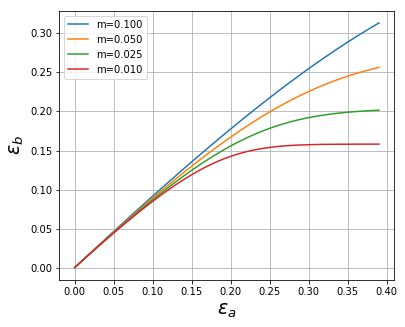

In [5]:
ms=[0.1,0.05,0.025,0.01]

fig=plt.figure(figsize=(6,5))

ax=fig.add_subplot(111)
lines=[]
for i in xrange(len(ms)):
    m=ms[i]
    x,y,fv=xy_curve(10,0.001,0.98,0.2,m)
    l,=ax.plot(x,y,'-',label=r'm=%.3f'%m)
    
    #x,y,fv=xy_curve(10,0.001,0.99,0.2,m)
    #l,=ax.plot(x,y,'--',color=l.get_color())
    #lines.append(l)
    
ax.set_xlabel(r'$\varepsilon_a$',fontsize=19)
ax.set_ylabel(r'$\varepsilon_b$',fontsize=19)
ax.legend()
ax.grid()
ax.set_aspect('equal')